# TimeAtlas

In [61]:
import timeatlas as ta
import pandas as pd
import numpy as np

## Load the data

In [62]:
s = pd.read_csv("../data/bbdata-weather/4652.csv")
s = pd.DataFrame(data=s["value"].values, index=pd.to_datetime(s["timestamp"]).values)
s.index = s.index.round("S")

In [63]:
ts = ta.TimeSeries(s)
ts[:5]

                     values
2016-02-14 14:03:33    6.80
2016-11-01 04:15:20    1.52
2016-11-14 06:57:36    9.84
2016-11-14 14:44:48    2.08
2016-11-14 15:10:02    1.92

## Plot the data

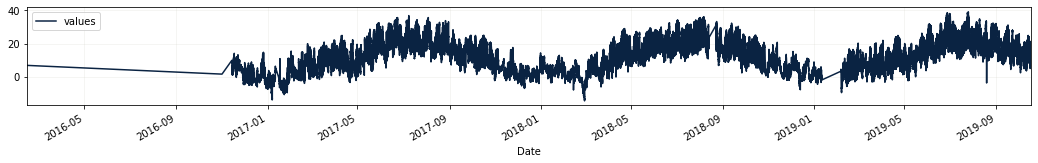

In [64]:
ts.plot()

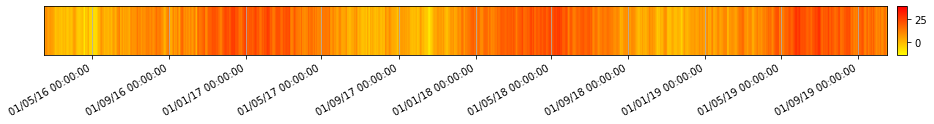

In [65]:
ta.plots.status(ts);

## Select the data

In [66]:
ts = ts["01-2018"]

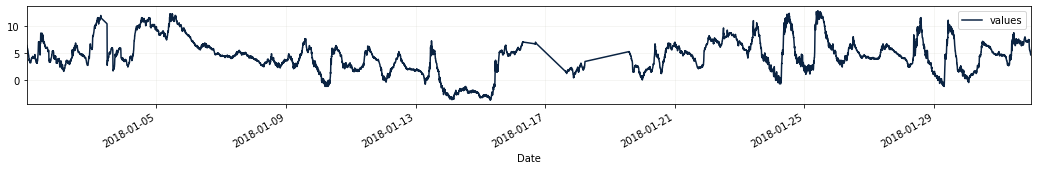

In [67]:
ts.plot()

### Check the data quality

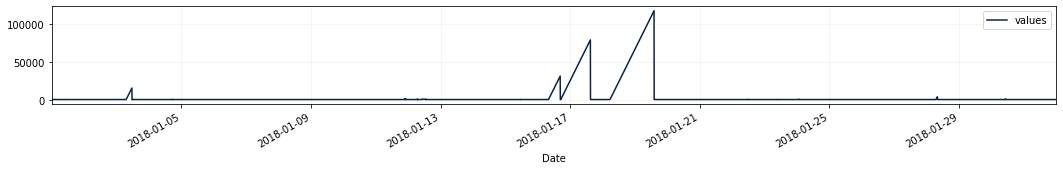

In [68]:
ta.plots.line(ts.resolution());

## Get some statistics

In [69]:
ts.boundaries()

(Timestamp('2018-01-01 00:02:44'), Timestamp('2018-01-31 23:55:54'))

In [70]:
ts.duration()

Timedelta('30 days 23:53:10')

In [71]:
ts.frequency() == None

True

Because it doesn't comply with Pandas offset aliases: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
So, let's resample:

In [72]:
ts = ts.resample("15min", method="pad")

In [73]:
ts.frequency()

'15T'

In [74]:
ts.min()

values   -3.68
dtype: float64

In [75]:
ts.max()

values    12.48
dtype: float64

In [76]:
ts.mean()

values    4.502796
dtype: float64

In [77]:
ts.kurtosis()

values    0.263586
dtype: float64

In [78]:
ts.skewness()

values   -0.026805
dtype: float64

## Transform the data

### Delete the values

In [79]:
ts.empty()[:5]

                    values
2018-01-01 00:02:44   None
2018-01-01 00:17:44   None
2018-01-01 00:32:44   None
2018-01-01 00:47:44   None
2018-01-01 01:02:44   None

### Apply functions on a single time series

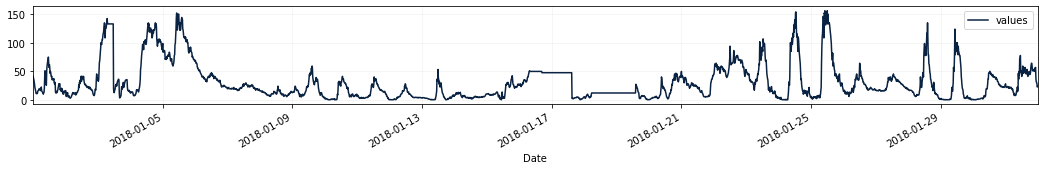

In [80]:
# with one argument
ts.apply(lambda x: x**2).plot()

### Apply functions between time series 

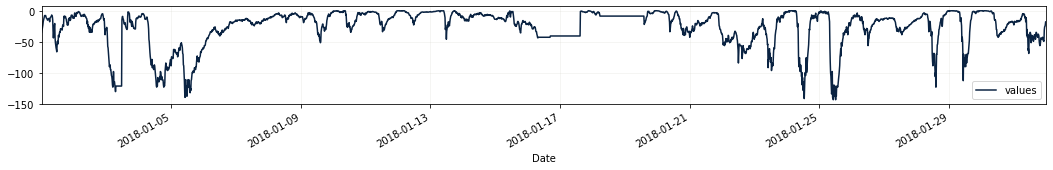

In [81]:
# with two argument (to mix values between two timeseries for instance)
ts.apply(lambda x,y: 0 - x**2 + y, ts).plot()

## Generate some data

In [82]:
ts2 = ta.TimeSeries.create("01-2020", "02-2020", "H")
ts2[:5]

                    values
2020-01-01 00:00:00    NaN
2020-01-01 01:00:00    NaN
2020-01-01 02:00:00    NaN
2020-01-01 03:00:00    NaN
2020-01-01 04:00:00    NaN

In [83]:
ts2 = ts2.fill(np.random.randint(0,100,len(ts2)))
ts2[:5]

                     values
2020-01-01 00:00:00      99
2020-01-01 01:00:00      96
2020-01-01 02:00:00      26
2020-01-01 03:00:00      80
2020-01-01 04:00:00      21

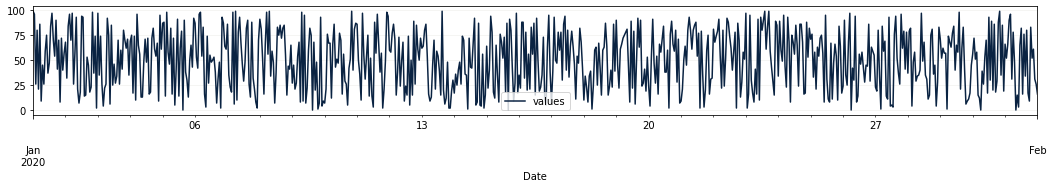

In [84]:
ts2.plot()

## Trim empty values

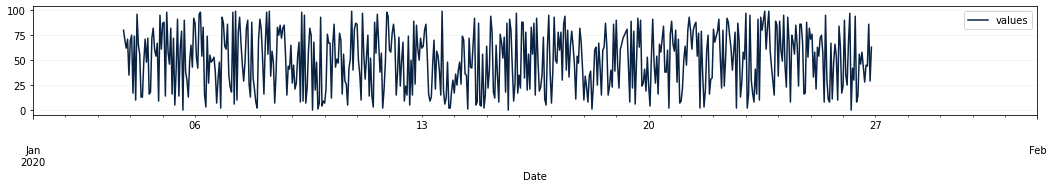

In [85]:
ts2.series[:67] = None
ts2.series[-123:] = None
ts2.plot()

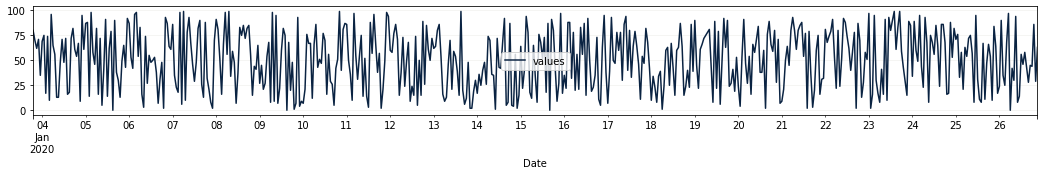

In [86]:
ts2.trim().plot()

## Add Metadata 

In [87]:
from timeatlas import Metadata, types

# You can use some typed metadata object
my_unit = types.Unit("degree", "°C", "float")
my_sensor = types.Sensor(4652, "HB/outside/weather/temperature")

# Or use Python dictionaries
my_location = {
    "building" : "Blue Factory",
    "floor" : "12",
    "room"  : "22C"
}
my_coordinates = {
    "lat" : 46.796611,
    "lon" : 7.147563
}
my_dict = {
    "unit": my_unit,
    "sensor": my_sensor,
    "location": my_location,
    "coordinates": my_coordinates
}

# Create the Metadata object
my_meta = Metadata(my_dict)


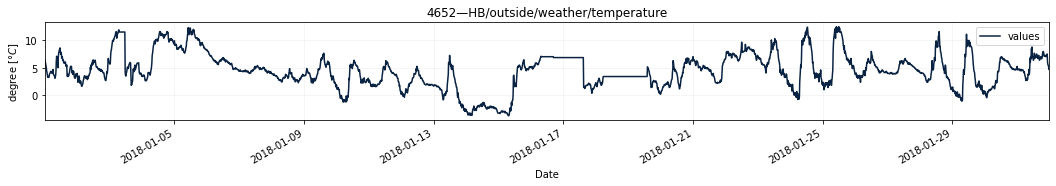

In [88]:
ts.metadata = my_meta
ts.plot()

## Model the data

### with Facebook Prophet

In [98]:
m1 = ta.models.Prophet()
m1.fit(ts)
pts1 = m1.predict("7 day")

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


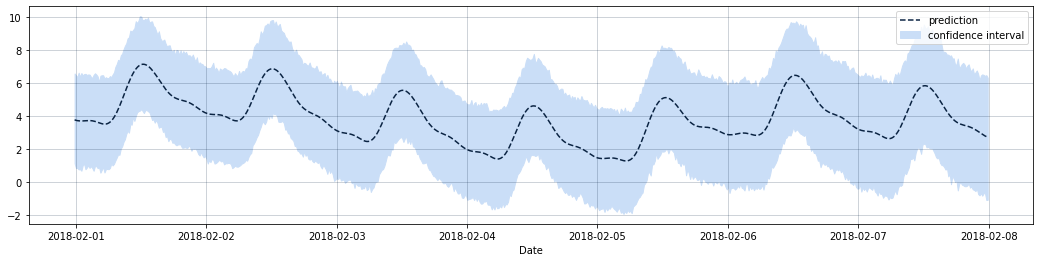

In [99]:
pts1.plot()

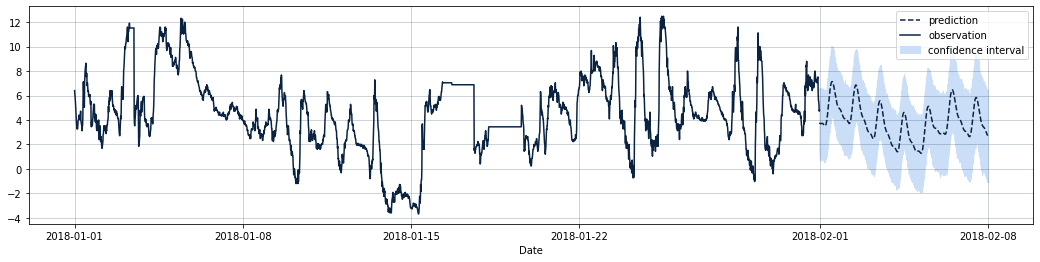

In [100]:
ta.plots.prediction(pts1, ts["2018-01":]);

### Or just make a linear regression...

In [102]:
m2 = ta.models.LinearRegression()
m2.fit(ts)
pts2 = m2.predict(ts)

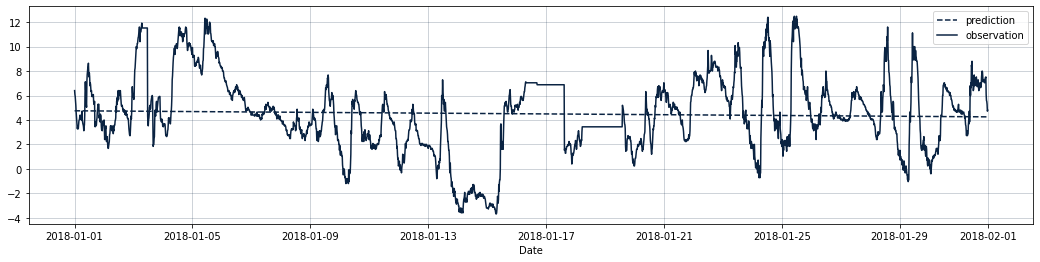

In [103]:
ta.plots.prediction(pts2, ts["2018-01":]);